<a href="https://colab.research.google.com/github/GeorgeM2000/Sports-Activity/blob/main/Sports_Activity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pydotplus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV # Import train_test_split function
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
from scipy.stats import randint

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
import graphviz

# Data Preprocessing

In [2]:
# Read excel file data
sport_data = pd.read_excel('Results_Saferun_2023_04_26_2_submit_With_Page.xlsx')

# Store it as csv file
sport_data.to_csv('Results_Saferun_2023_04_26_2_submit_With_Page.csv', index=False)

# Read csv file data
sport_data = pd.DataFrame(pd.read_csv('Results_Saferun_2023_04_26_2_submit_With_Page.csv'))

In [ ]:
sport_data.head()

,Weight,Height,Gender,Age,Running experience (years),"1) Do you feel any musculoskeletal discomfort (e.g pain, tightness, heaviness) related to your running activity?",2) Είδος πόνου,"IF YES, in which area of the body do you feel the symptom?",Pain intensity;,The symptom starts,The symptom lasts,pain intensity is,Does the symptom affect running?,Does the symptom affect everyday life?,"Does the symptom affect every day functional activities e.g walking, ascending or descending stairs ?",Page
0,84,176,Male,45,3.0,Yes,NaN,Calf,a,a,a,a,a,a,a,5
1,85,176,Male,45,4.0,Yes,NaN,Sole,a,a,a,a,a,a,a,5
2,25,154,Female,45,5.0,Yes,NaN,Knee,c,b,c,b,b,a,a,5
3,55,176,Male,38,9.0,Yes,NaN,Knee,c,c,b,b,c,a,b,5
4,56,170,Female,51,2.0,Yes,NaN,Hip,b,b,b,c,a,b,b,3


Column "2) Είδος πόνου" has null values for every row of the dataset so we remove it. Also, we rename some of the columns of the dataset in order to have a more concise form of the dataframe.

In [3]:
sport_data.drop(columns={'2) Είδος πόνου'}, inplace=True)

In [4]:
sport_data.rename(
    columns={'1) Do you feel any musculoskeletal discomfort (e.g pain, tightness, heaviness) related to your running activity?': 'Musculoskeletal discomfort',
             'IF YES, in which area of the body do you feel the symptom?': 'Symptom area',
             'Pain intensity;': 'Pain intensity',
             'Running experience (years)': 'Experience',
             'The symptom starts': 'Irritability(WHEN)',
             'The symptom lasts': 'Irritability(DURATION)',
             'pain intensity is': 'Irritability(INTENSITY)',
             'Does the symptom affect running?': 'Severity(RUNNING)',
             'Does the symptom affect everyday life?': 'Severity(LIFE)',
             'Does the symptom affect every day functional activities e.g walking, ascending or descending stairs ?': 'Severity(MOBILITY)'
             },
    inplace=True)

In [ ]:
sport_data.head()

,Weight,Height,Gender,Age,Experience,Musculoskeletal discomfort,Symptom area,Pain intensity,Irritability(WHEN),Irritability(DURATION),Irritability(INTENSITY),Severity(RUNNING),Severity(LIFE),Severity(MOBILITY),Page
0,84,176,Male,45,3.0,Yes,Calf,a,a,a,a,a,a,a,5
1,85,176,Male,45,4.0,Yes,Sole,a,a,a,a,a,a,a,5
2,25,154,Female,45,5.0,Yes,Knee,c,b,c,b,b,a,a,5
3,55,176,Male,38,9.0,Yes,Knee,c,c,b,b,c,a,b,5
4,56,170,Female,51,2.0,Yes,Hip,b,b,b,c,a,b,b,3


In [ ]:
sport_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Weight                      84 non-null     int64  
 1   Height                      84 non-null     int64  
 2   Gender                      84 non-null     object 
 3   Age                         84 non-null     int64  
 4   Experience                  81 non-null     float64
 5   Musculoskeletal discomfort  83 non-null     object 
 6   Symptom area                84 non-null     object 
 7   Pain intensity              84 non-null     object 
 8   Irritability(WHEN)          84 non-null     object 
 9   Irritability(DURATION)      84 non-null     object 
 10  Irritability(INTENSITY)     84 non-null     object 
 11  Severity(RUNNING)           84 non-null     object 
 12  Severity(LIFE)              84 non-null     object 
 13  Severity(MOBILITY)          84 non-nu

In [ ]:
pd.DataFrame(sport_data.isnull().sum(), columns=["No. Missing Values"])

,No. Missing Values
Weight,0
Height,0
Gender,0
Age,0
Experience,3
Musculoskeletal discomfort,1
Symptom area,0
Pain intensity,0
Irritability(WHEN),0
Irritability(DURATION),0


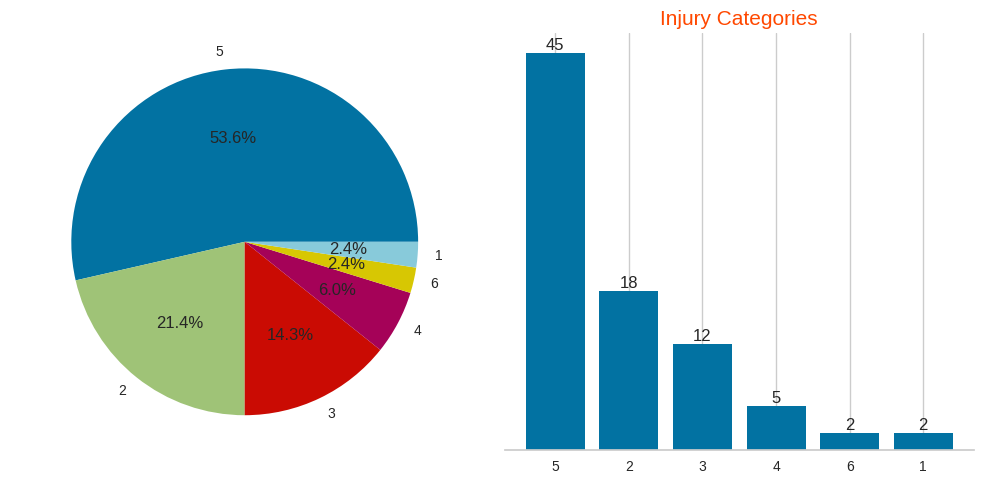

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

injury_categories = {6: '6', 5: '5', 4: '4', 3: '3', 2: '2', 1: '1'}

ax1.pie(sport_data[:]['Page'].value_counts().values, 
        labels = np.array([injury_categories[page] for page in sport_data[:]['Page'].value_counts().index]), 
        autopct = '%1.1f%%') 

ax1.axis('equal')


ax2.bar(np.array([injury_categories[page] for page in sport_data[:]['Page'].value_counts().index]), sport_data[:]['Page'].value_counts().values)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(axis='both', which='both', labelsize=10, left=False, bottom=False)
ax2.get_yaxis().set_visible(False)
plt.title("Injury Categories", fontsize=15, color = '#ff4800');

ax2.bar_label(ax2.containers[0])
fig.tight_layout()

In [5]:
def create_main_factor_list(row):
  """
  There are 3 main factors contributing to the classification of an athlete. 
  PAIN, IRRITABILITY and SEVERITY. IRRITABILITY can be formulated by the combination of the 3 following columns:

    i1) Irritability(WHEN)
    i2) Irritability(DURATION)
    i3) Irritability(INTENSITY)

  and SEVERITY:

    s1) Severity(RUNNING)
    s2) Severity(LIFE)
    s3) Severity(MOBILITY)

  The PAIN factor is determined by the value present in each row of the column "Pain Intensity".
  PAIN can have 4 different values (a, b, c, d) based on the answers of the questionnaire:

    a = 0 (numerical value of a)
    b = 1 (numerical value of b)
    c = 2 (numerical value of c)
    d = 3 (numerical value of d)

  IRRITABILITY can have 3 different values (HIGH, MODERATE, LOW) based on the answers of the questionnaire:

    a, a, a = HIGH     = 2 (numerical value of HIGH)
    other   = MODERATE = 1 (numerical value of MODERATE)
    c, c, c = LOW      = 0 (numerical value of LOW)

  SEVERITY can have 3 different values (HIGH, MODERATE, LOW) based on the answers of the questionnaire:

    a, b, b = LOW = 0
    b, b, b = MODERATE = 1
    other = HIGH = 2

  """  

  # 1st element in "factor_list" represents the PAIN factor value.
  factor_list = [row[7]] 
  
  # 2nd element in "factor_list" represents the IRRITABILITY factor value.
  if (row[8] + row[9] + row[10]) == 0: # If irritability(WHEN, DURATION, INTENSITY) are all answered with 'a'
    factor_list.append(2)
  elif (row[8] + row[9] + row[10]) == 6: # If irritability(WHEN, DURATION, INTENSITY) are all answered with 'c'
    factor_list.append(0)
  else: # Otherwise
    factor_list.append(1)

  # 3rd element in "factor_list" represents the SEVERITY factor value.
  if (row[11] == 0) and (row[12] == 1) and (row[13] == 1): # If irritability(WHEN, DURATION, INTENSITY) are all answered with 'a'
    factor_list.append(0)
  elif (row[11] == 1) and (row[12] == 1) and (row[13] == 1): # If irritability(WHEN, DURATION, INTENSITY) are all answered with 'c'
    factor_list.append(1)
  else: # Otherwise
    factor_list.append(2)

  return factor_list


In [ ]:
def classify_sample(sample, dataframe):
  combinations = {
      'aaa':1,
      'aab':2,
      'bab':3, 'baa':3,
      'abc':4, 'abb':4, 'aba':4, 'bbc':4, 'bbb':4, 'bba':4,
      'aac':5, 'aoc':5, 'aob':5, 'aoa':5, 'bac':5, 'boc':5, 'bob':5, 'boa':5,
  }

  answers = ''
  for indicator_value in sample[2:-1]: 
    answers += str(indicator_value)

  if answers.split()[0] == 'c' or answers.split()[0] == 'd':
    dataframe[]


      
  

We have to convert the nominal variables to numerical variables.

In [6]:
pain                   = {'a': 0, 'b': 1, 'c': 2, 'd': 3}
irritability           = {'a': 0, 'b': 1, 'c':2}
severity               = {
                          'RUNNING': {'a': 0, 'b': 1, 'c': 2},
                          'LIFE_MOBILITY': {'a': 0, 'b': 1}
                        }

In [7]:
# Pain Intensity
sport_data['Pain intensity'] = [pain[sport_data['Pain intensity'][row]] for row in range(sport_data.shape[0])]

# Irritability(WHEN, DURATION, INTENSITY)
sport_data['Irritability(WHEN)'] = [irritability[sport_data['Irritability(WHEN)'][row]] for row in range(sport_data.shape[0])]
sport_data['Irritability(DURATION)'] = [irritability[sport_data['Irritability(DURATION)'][row]] for row in range(sport_data.shape[0])]
sport_data['Irritability(INTENSITY)'] = [irritability[sport_data['Irritability(INTENSITY)'][row]] for row in range(sport_data.shape[0])]

# Severity(RUNNING)
sport_data['Severity(RUNNING)'] = [severity['RUNNING'][sport_data['Severity(RUNNING)'][row]] for row in range(sport_data.shape[0])]

# Severity(LIFE, MOBILITY)
sport_data['Severity(LIFE)'] = [severity['LIFE_MOBILITY'][sport_data['Severity(LIFE)'][row]] for row in range(sport_data.shape[0])]
sport_data['Severity(MOBILITY)'] = [severity['LIFE_MOBILITY'][sport_data['Severity(MOBILITY)'][row]] for row in range(sport_data.shape[0])]

In [8]:
sport_data['Pain intensity']          = sport_data['Pain intensity'].astype('int64')
sport_data['Irritability(WHEN)']      = sport_data['Irritability(WHEN)'].astype('int64') 
sport_data['Irritability(DURATION)']  = sport_data['Irritability(DURATION)'].astype('int64') 
sport_data['Irritability(INTENSITY)'] = sport_data['Irritability(INTENSITY)'].astype('int64') 
sport_data['Severity(RUNNING)']       = sport_data['Severity(RUNNING)'].astype('int64') 
sport_data['Severity(LIFE)']          = sport_data['Severity(LIFE)'].astype('int64')  
sport_data['Severity(MOBILITY)']      = sport_data['Severity(MOBILITY)'].astype('int64')  

In [ ]:
sport_data.head()

,Weight,Height,Gender,Age,Experience,Musculoskeletal discomfort,Symptom area,Pain intensity,Irritability(WHEN),Irritability(DURATION),Irritability(INTENSITY),Severity(RUNNING),Severity(LIFE),Severity(MOBILITY),Page
0,84,176,Male,45,3.0,Yes,Calf,0,0,0,0,0,0,0,5
1,85,176,Male,45,4.0,Yes,Sole,0,0,0,0,0,0,0,5
2,25,154,Female,45,5.0,Yes,Knee,2,1,2,1,1,0,0,5
3,55,176,Male,38,9.0,Yes,Knee,2,2,1,1,2,0,1,5
4,56,170,Female,51,2.0,Yes,Hip,1,1,1,2,0,1,1,3


In [ ]:
sport_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Weight                      84 non-null     int64  
 1   Height                      84 non-null     int64  
 2   Gender                      84 non-null     object 
 3   Age                         84 non-null     int64  
 4   Experience                  81 non-null     float64
 5   Musculoskeletal discomfort  83 non-null     object 
 6   Symptom area                84 non-null     object 
 7   Pain intensity              84 non-null     int64  
 8   Irritability(WHEN)          84 non-null     int64  
 9   Irritability(DURATION)      84 non-null     int64  
 10  Irritability(INTENSITY)     84 non-null     int64  
 11  Severity(RUNNING)           84 non-null     int64  
 12  Severity(LIFE)              84 non-null     int64  
 13  Severity(MOBILITY)          84 non-nu

In [9]:
symptom_area = {
    'Calf': 0,
    'Hip': 1,
    'Knee': 2,
    'Low back': 3,
    'Sole': 4,
    'Thigh': 5
}

In [10]:
data = {
    'Weight': list(sport_data['Weight'][:]),
    'height': list(sport_data['Height'][:]),
    'Gender': list(sport_data['Gender'][:]),
    'Age': list(sport_data['Age'][:]),
    'Experience': list(sport_data['Experience'][:]),
    'Musculoskeletal discomfort': list(sport_data['Musculoskeletal discomfort'][:]),
    'Symptom area': list(map(lambda sa: symptom_area[sa], sport_data['Symptom area'][:])),
    'PAIN': [],
    'IRRITABILITY': [],
    'SEVERITY': [],
    'Page': list(sport_data['Page'][:]),
}

for row in range(sport_data.shape[0]):
  factor_list = create_main_factor_list(sport_data.iloc[row])
  data['PAIN'].append(factor_list[0])
  data['IRRITABILITY'].append(factor_list[1])
  data['SEVERITY'].append(factor_list[2])


# Create a new dataframe for classification
sport_data_classification = pd.DataFrame(data=data)

In [11]:
sport_data_classification['Symptom area'] = sport_data_classification['Symptom area'].astype('int64')

In [ ]:
sport_data_classification.head()

,Weight,height,Gender,Age,Experience,Musculoskeletal discomfort,Symptom area,PAIN,IRRITABILITY,SEVERITY,Page
0,84,176,Male,45,3.0,Yes,0,0,2,2,5
1,85,176,Male,45,4.0,Yes,4,0,2,2,5
2,25,154,Female,45,5.0,Yes,2,2,1,2,5
3,55,176,Male,38,9.0,Yes,2,2,1,2,5
4,56,170,Female,51,2.0,Yes,1,1,1,0,3


In [ ]:
sport_data_classification.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Weight                      84 non-null     int64  
 1   height                      84 non-null     int64  
 2   Gender                      84 non-null     object 
 3   Age                         84 non-null     int64  
 4   Experience                  81 non-null     float64
 5   Musculoskeletal discomfort  83 non-null     object 
 6   Symptom area                84 non-null     int64  
 7   PAIN                        84 non-null     int64  
 8   IRRITABILITY                84 non-null     int64  
 9   SEVERITY                    84 non-null     int64  
 10  Page                        84 non-null     int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 7.3+ KB


# Classification

## Classification Helper Functions

In [12]:
def show_decision_tree_classifier(model, features):
  dot_data = StringIO()
  export_graphviz(model, 
                  out_file=dot_data,  
                  filled=True, 
                  rounded=True,
                  special_characters=True,
                  feature_names=features,
                  class_names=['1', '2', '3', '4', '5', '6'])

  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
  graph.write_png('DecisionTree.png')

  return graph


In [13]:
def create_clusters(labels, dataframe):
  clusters = [[] for _ in range(len(np.unique(labels)))]
  
  for label_index in range(len(labels)):
    clusters[labels[label_index]].append(dataframe.iloc[label_index]['Age'])
  
  return clusters

## Decision Tree Classifier 1

In this subsection we utilize the decision tree classifier class for three features of the dataset named  

- PAIN
- IRRITABILITY
- SEVERITY

We test the classifier for a predefined splitting percentage value. 



Scikit-learn uses an optimized version of the CART algorithm and the implementation does not support categorical variables.

CART (Classification and Regression Trees) is very similar to C4.5, but it differs in that it supports numerical target variables (regression) and does not compute rule sets. CART constructs binary trees using the feature and threshold that yield the largest information gain at each node.

C4.5 is the successor to ID3 and removed the restriction that features must be categorical by dynamically defining a discrete attribute (based on numerical variables) that partitions the continuous attribute value into a discrete set of intervals. C4.5 converts the trained trees (i.e. the output of the ID3 algorithm) into sets of if-then rules. The accuracy of each rule is then evaluated to determine the order in which they should be applied. Pruning is done by removing a rule's precondition if the accuracy of the rule improves without it.

ID3 (Iterative Dichotomiser 3) was developed in 1986 by Ross Quinlan. The algorithm creates a multiway tree, finding for each node (i.e. in a greedy manner) the categorical feature that will yield the largest information gain for categorical targets. Trees are grown to their maximum size and then a pruning step is usually applied to improve the ability of the tree to generalize to unseen data.

In [ ]:
# Split dataset 'sport_data_classification' in features and target variable
X = sport_data_classification[['PAIN', 'IRRITABILITY', 'SEVERITY']]
Y = sport_data_classification.Page

In [ ]:
# Split dataset into training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train, Y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

In [ ]:
# Model Accuracy
print("Accuracy:", accuracy_score(Y_test, y_pred))

# Model F-Score
print("F-Score:", f1_score(Y_test, y_pred, average='macro'))

Accuracy: 0.9523809523809523


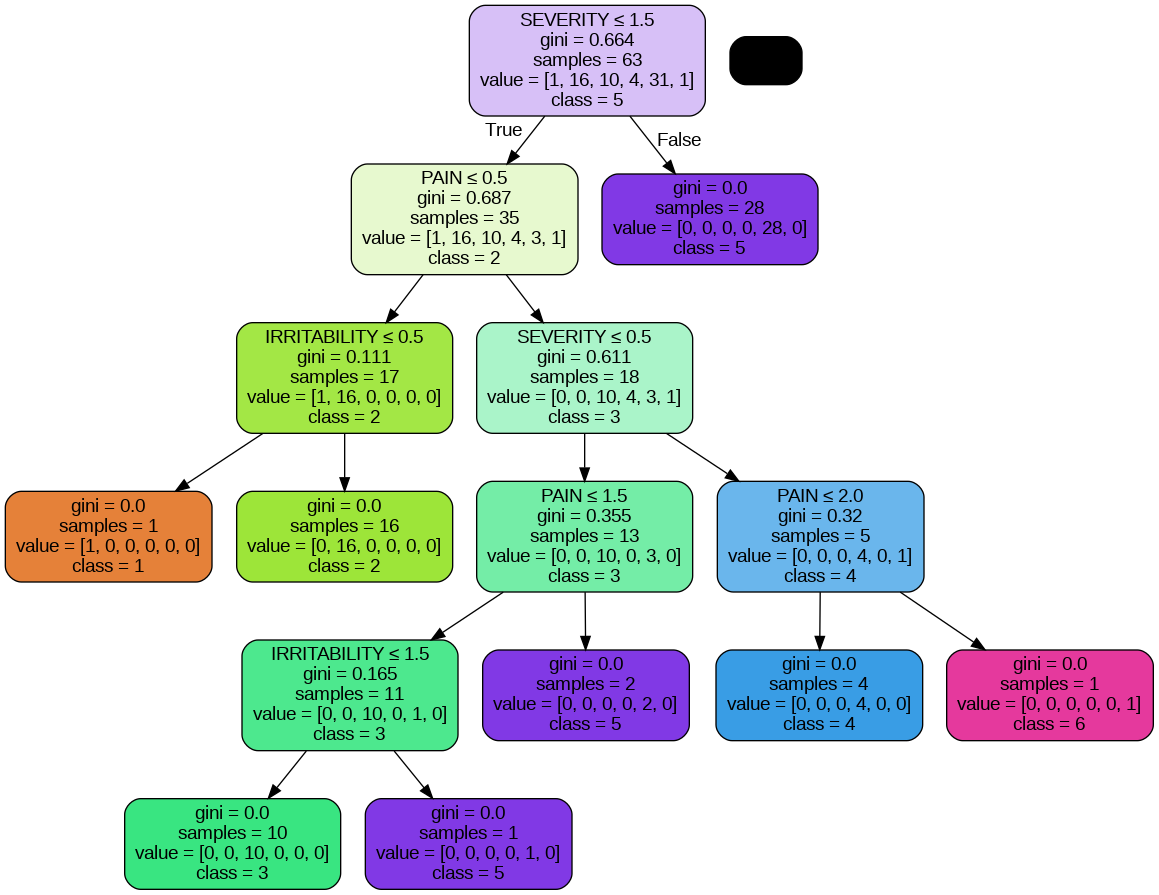

In [ ]:
Image(show_decision_tree_classifier(clf, ['PAIN', 'IRRITABILITY', 'SEVERITY']).create_png())

## Decision Tree Classifier 2

In this subsection we utilize the decision tree classifier class for three features of the dataset named  

- PAIN
- IRRITABILITY
- SEVERITY

We test the classifier for a list of splitting percentage values.

In [ ]:
# Split dataset 'sport_data_classification' in features and target variable
X = sport_data_classification[['PAIN', 'IRRITABILITY', 'SEVERITY']]
Y = sport_data_classification.Page

In [ ]:
model_accuracies = {}
splittings = list(np.arange(0.05, 0.55, 0.05))

for splitting_perc in splittings:
  
  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Split dataset into training set and test set
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=splitting_perc, random_state=1)

  # Train Decision Tree Classifer
  clf = clf.fit(X_train, Y_train)

  # Predict the response for test dataset
  y_pred = clf.predict(X_test)

  accuracy = accuracy_score(Y_test, y_pred)
  f_score = f1_score(Y_test, y_pred, average='macro')

  model_accuracies[round(splitting_perc, 2)] = [f_score, clf]

  # Model Accuracy, how often is the classifier correct?
  print(f'Splitting(%): {splitting_perc} Accuracy: {accuracy} F-Score: {f_score}')

Splitting(%): 0.05 Accuracy: 1.0
Splitting(%): 0.1 Accuracy: 0.8888888888888888
Splitting(%): 0.15000000000000002 Accuracy: 0.9230769230769231
Splitting(%): 0.2 Accuracy: 0.9411764705882353
Splitting(%): 0.25 Accuracy: 0.9523809523809523
Splitting(%): 0.3 Accuracy: 0.9230769230769231
Splitting(%): 0.35000000000000003 Accuracy: 0.9333333333333333
Splitting(%): 0.4 Accuracy: 0.9411764705882353
Splitting(%): 0.45 Accuracy: 0.9473684210526315
Splitting(%): 0.5 Accuracy: 0.9047619047619048


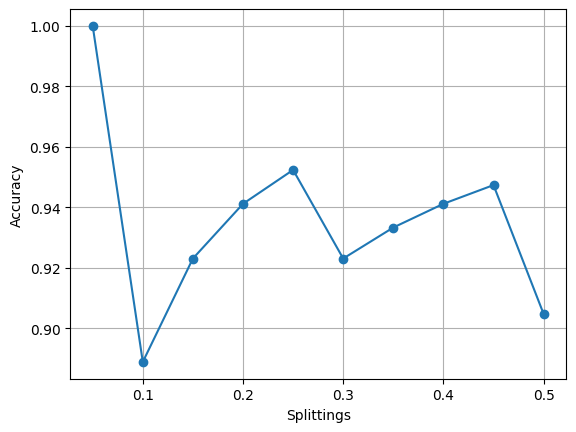

In [ ]:
plt.plot(np.array(splittings), np.array(list(map(lambda value: value[0], model_accuracies.values()))), marker='o')
plt.grid(True)
plt.xlabel('Splittings')
plt.ylabel('Accuracy')
plt.show()

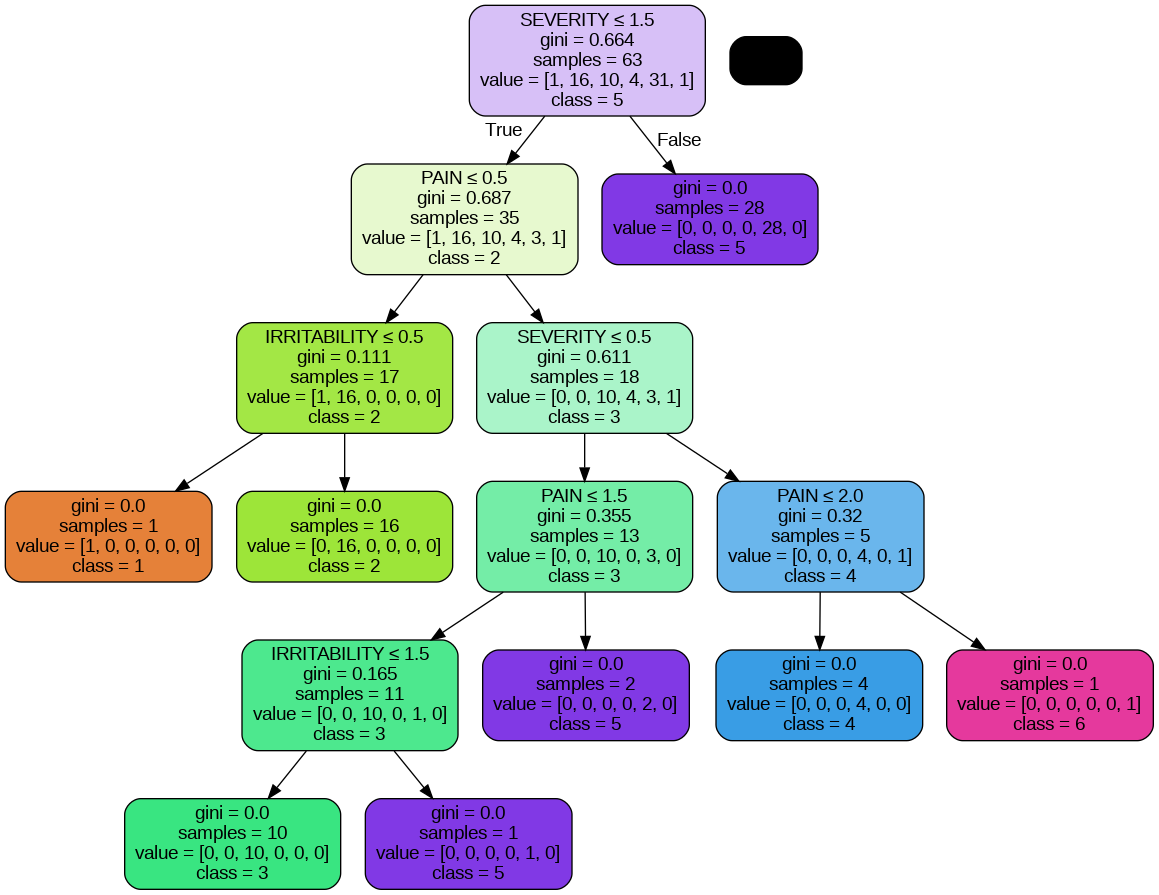

In [ ]:
Image(show_decision_tree_classifier(model_accuracies[0.25][1], ['PAIN', 'IRRITABILITY', 'SEVERITY']).create_png())

## Decision Tree Classifier 3
In this subsection we utilize the decision tree classifier class for five features of the dataset named  

- Age
- Symptom Area
- PAIN
- IRRITABILITY
- SEVERITY

We test the classifier for a list of splitting percentage values.

In [14]:
# Split dataset 'sport_data_classification' in features and target variable
X = sport_data_classification[['Age', 'Symptom area', 'PAIN', 'IRRITABILITY', 'SEVERITY']]
Y = sport_data_classification.Page

In [15]:
sorted_ages = np.sort(np.array(list(X['Age'])))
print(sorted_ages)

[16 17 19 21 21 23 23 25 25 25 25 25 25 25 26 29 32 33 34 37 38 38 39 40
 41 41 42 44 44 44 45 45 45 45 45 45 45 45 45 45 45 45 45 46 46 46 46 46
 46 46 46 48 48 48 48 49 50 50 50 50 50 50 50 50 51 51 51 52 53 54 55 55
 55 56 56 57 58 58 58 60 60 60 61 65]


### Clustering

The maximum age in the dataset is 65, the minimum is 16, and there are 84 samples. In order to acquire a high accuracy classification model, the values of the "Age" feature must be grouped. Clustering methods can help with this particular task. Before clustering, the optimal number of clusters must be found. Therefore, the Elbow method is used. To use the elbow method, the maximum and minimum number of clusters must be defined. The minimum number of clusters will be 2, and the maximum will be 49(65 - 16) due to the fact that each age can have a unique cluster accosiated with it.

In [16]:
cluster_data = np.array(list(X['Age']))
cluster_data = np.reshape(cluster_data, (cluster_data.shape[0], 1))

In [17]:
print("Max Age: {max_age}".format(max_age = max(list(X['Age']))))
print("Min Age: {min_age}".format(min_age = min(list(X['Age']))))

Max Age: 65
Min Age: 16


/usr/local/lib/python3.10/dist-packages/yellowbrick/cluster/elbow.py:339: ConvergenceWarning: Number of distinct clusters (34) found smaller than n_clusters (35). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/usr/local/lib/python3.10/dist-packages/yellowbrick/cluster/elbow.py:339: ConvergenceWarning: Number of distinct clusters (34) found smaller than n_clusters (36). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/usr/local/lib/python3.10/dist-packages/yellowbrick/cluster/elbow.py:339: ConvergenceWarning: Number of distinct clusters (34) found smaller than n_clusters (37). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/usr/local/lib/python3.10/dist-packages/yellowbrick/cluster/elbow.py:339: ConvergenceWarning: Number of distinct clusters (34) found smaller than n_clusters (38). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/usr/local/lib/python3.10/dist-packages/yellowbrick/clus

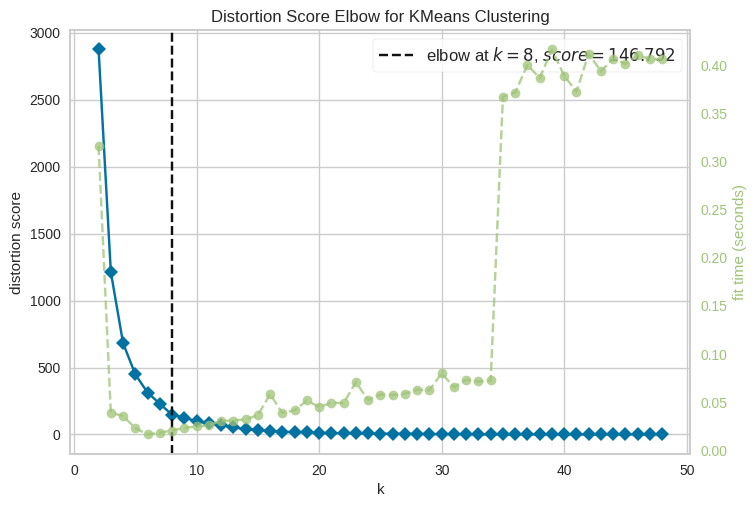

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
# Apply the elbow method
kmeans_elbow_method = KMeans(init='k-means++', n_init=10)
kmeans_elbow_visualizer = KElbowVisualizer(kmeans_elbow_method, k=(2, 49))

kmeans_elbow_visualizer.fit(cluster_data)
kmeans_elbow_visualizer.show()

In [19]:
kmeans = KMeans(n_clusters=8, n_init=10)
kmeans_labels = kmeans.fit_predict(cluster_data)

In [20]:
kmeans_clusters = create_clusters(kmeans_labels, X)

In [21]:
age_groups = []
for cluster in kmeans_clusters:
  age_groups.append([min(cluster), max(cluster)])

age_groups.sort(key = lambda cluster: cluster[0])

In [22]:
age_groups

[[16, 21],
 [23, 26],
 [29, 34],
 [37, 42],
 [44, 46],
 [48, 53],
 [54, 58],
 [60, 65]]

### Classification

In [23]:
# Define age group boundaries
bins = []

for age_group in age_groups:
  bins.append(age_group[0])

bins.append(age_groups[-1][1])

In [24]:
bins

[16, 23, 29, 37, 44, 48, 54, 60, 65]

In [25]:
X['Age'] = pd.cut(X['Age'], bins, include_lowest=True,labels=list(range(0,8)))

<ipython-input-25-019de19c55c6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Age'] = pd.cut(X['Age'], bins, include_lowest=True,labels=list(range(0,8)))


In [26]:
X.head()

,Age,Symptom area,PAIN,IRRITABILITY,SEVERITY
0,4,0,0,2,2
1,4,4,0,2,2
2,4,2,2,1,2
3,3,2,2,1,2
4,5,1,1,1,0


In [34]:
model_accuracies = {}
splittings = list(np.arange(0.05, 0.55, 0.05))

for splitting_perc in splittings:
  
  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier()

  # Split dataset into training set and test set
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=splitting_perc, random_state=1)

  # Train Decision Tree Classifer
  clf = clf.fit(X_train, Y_train)

  # Predict the response for test dataset
  y_pred = clf.predict(X_test)

  accuracy = accuracy_score(Y_test, y_pred)
  f_score = f1_score(Y_test, y_pred, average='macro')

  model_accuracies[round(splitting_perc, 2)] = [f_score, clf]

  # Model Accuracy, how often is the classifier correct?
  print(f'Splitting(%): {splitting_perc} Accuracy: {accuracy} F1 Score: {f_score}')

Splitting(%): 0.05 Accuracy: 1.0 F1 Score: 1.0
Splitting(%): 0.1 Accuracy: 0.8888888888888888 F1 Score: 0.8888888888888888
Splitting(%): 0.15000000000000002 Accuracy: 0.9230769230769231 F1 Score: 0.9230769230769231
Splitting(%): 0.2 Accuracy: 0.9411764705882353 F1 Score: 0.9411764705882353
Splitting(%): 0.25 Accuracy: 0.9523809523809523 F1 Score: 0.9523809523809523
Splitting(%): 0.3 Accuracy: 0.9230769230769231 F1 Score: 0.9230769230769231
Splitting(%): 0.35000000000000003 Accuracy: 0.9333333333333333 F1 Score: 0.9333333333333333
Splitting(%): 0.4 Accuracy: 0.9411764705882353 F1 Score: 0.9411764705882353
Splitting(%): 0.45 Accuracy: 0.9473684210526315 F1 Score: 0.9473684210526315
Splitting(%): 0.5 Accuracy: 0.9047619047619048 F1 Score: 0.9047619047619048


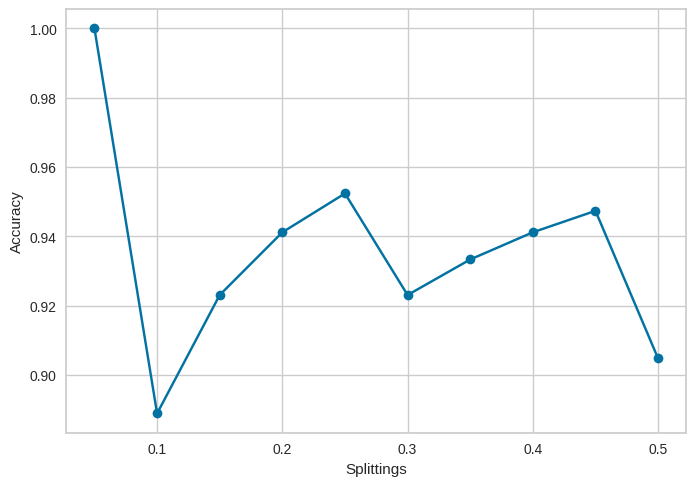

In [28]:
plt.plot(np.array(splittings), np.array(list(map(lambda value: value[0], model_accuracies.values()))), marker='o')
plt.grid(True)
plt.xlabel('Splittings')
plt.ylabel('Accuracy')
plt.show()

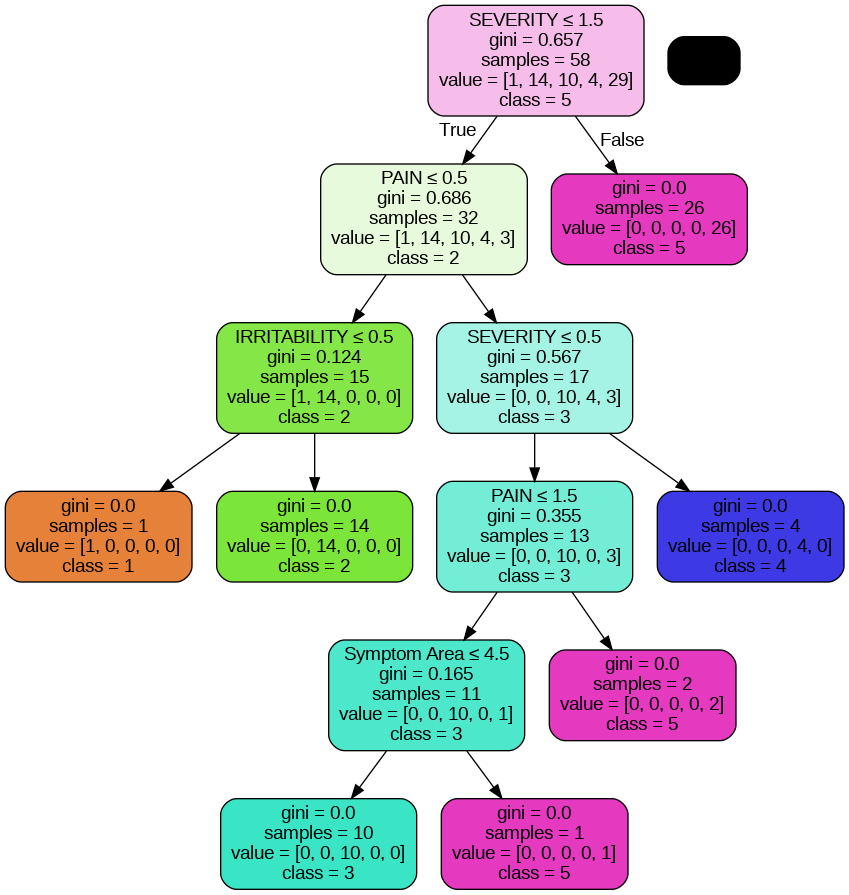

In [29]:
Image(show_decision_tree_classifier(model_accuracies[0.30][1], ['Age', 'Symptom Area', 'PAIN', 'IRRITABILITY', 'SEVERITY']).create_png())

## Random Forest Classifier 1

In this subsection we utilize the random forest classifier class for five features of the dataset named  

- Age
- Symptom Area
- PAIN
- IRRITABILITY
- SEVERITY

We test the classifier for a predefined splitting percentage value.

In [ ]:
X = sport_data_classification[['Age', 'Symptom area', 'PAIN', 'IRRITABILITY', 'SEVERITY']]
Y = sport_data_classification.Page

In [ ]:
# Define age group boundaries
bins = []
#bins = pd.IntervalIndex.from_tuples([(age_group[0], age_group[1]) for age_group in age_groups])

for age_group in age_groups:
  bins.append(age_group[0])

bins.append(age_groups[-1][1])

In [ ]:
X['Age'] = pd.cut(X['Age'], bins, include_lowest=True,labels=list(range(0,8)))

<ipython-input-123-019de19c55c6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Age'] = pd.cut(X['Age'], bins, include_lowest=True,labels=list(range(0,8)))


In [ ]:
# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
y_pred = rf.predict(X_test)

In [ ]:
accuracy = accuracy_score(Y_test, y_pred)
f_score = f1_score(Y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("F-Score: ", f_score)

Accuracy: 0.8846153846153846


In [ ]:
for i in range(3):
  tree = rf.estimators_[i]
  dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               impurity=False, 
                               proportion=True)
  graph = graphviz.Source(dot_data)
  display(graph)

## Random Forest Classifier 2

In this subsection we utilize the random forest classifier class with hyperparameter tuning for five features of the dataset named  

- Age
- Symptom Area
- PAIN
- IRRITABILITY
- SEVERITY

We test the classifier for a predefined splitting percentage value.

In [ ]:
X = sport_data_classification[['Age', 'Symptom area', 'PAIN', 'IRRITABILITY', 'SEVERITY']]
Y = sport_data_classification.Page

In [ ]:
# Define age group boundaries
bins = []
#bins = pd.IntervalIndex.from_tuples([(age_group[0], age_group[1]) for age_group in age_groups])

for age_group in age_groups:
  bins.append(age_group[0])

bins.append(age_groups[-1][1])

In [ ]:
X['Age'] = pd.cut(X['Age'], bins, include_lowest=True,labels=list(range(0,8)))

<ipython-input-139-019de19c55c6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Age'] = pd.cut(X['Age'], bins, include_lowest=True,labels=list(range(0,8)))


In [ ]:
# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

In [ ]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f1370d1fee0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f1370d1cb20>})

In [ ]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 7, 'n_estimators': 241}


In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=241, max_depth=7)
rf_classifier.fit(X_train, Y_train)
y_pred = rf_classifier.predict(X_test)

In [ ]:
accuracy = accuracy_score(Y_test, y_pred)
f_score = f1_score(Y_test, y_pred)
print("Accuracy:", accuracy)
print("F-Score:", f_score)

Accuracy: 0.9047619047619048


In [ ]:
for i in range(3):
  tree = rf_classifier.estimators_[i]
  dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               impurity=False, 
                               proportion=True)
  graph = graphviz.Source(dot_data)
  display(graph)